# Differences in Capitalization in Spam and Non-Spam Email

## Introduction

The `Spambase` dataset is a collection of assorted emails. Its variables include the frequencies of various words, lengths of capital letter sequences, and class: spam(1) or non-spam(0).

Spam email is unsolicited bulk email, often explicit or commercial, and has been an issue since the 1990s (Cranor et al., 1998, p.74). Spam is low-cost to send, but burdens service providers and recipients. While declining as of 2013, spam has become sophisticated, disguising itself from filters (Irani et al., 2013, p.2).

Due to spam's increasing complexity, additional work is needed to increase the efficacy of its detection. To assist the construction of more practical spam filters, we will look for consistent content differences between spam and non-spam. We focus on the average length of sequences of capital letters, assuming that spam likely uses capitalization to create false urgency and garner attention.

The question we set out to answer is:

**"Is the mean average length of uninterrupted sequences of capital letters different for spam and non-spam email?"**

## Preliminary Results

We will first load the needed packages.

In [1]:
library(tidyverse)
library(repr)
library(cowplot)
library(infer)
library(broom)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [2]:
spambase <- read.csv("https://raw.githubusercontent.com/rchanpra/stat-201-project/main/spambase/spambase.data")

In [3]:
colnames(spambase) <- c("word_freq_make","word_freq_address","word_freq_all","word_freq_3d","word_freq_our",
                        "word_freq_over","word_freq_remove","word_freq_internet","word_freq_order","word_freq_mail",
                        "word_freq_receive","word_freq_will","word_freq_people","word_freq_report","word_freq_addresses",
                        "word_freq_free","word_freq_business","word_freq_email","word_freq_you","word_freq_credit",
                        "word_freq_your","word_freq_font","word_freq_000","word_freq_money","word_freq_hp",
                        "word_freq_hpl","word_freq_george","word_freq_650","word_freq_lab","word_freq_labs",
                        "word_freq_telnet","word_freq_857","word_freq_data","word_freq_415","word_freq_85",
                        "word_freq_technology","word_freq_1999","word_freq_parts","word_freq_pm","word_freq_direct",
                        "word_freq_cs","word_freq_meeting","word_freq_original","word_freq_project", "word_freq_re",
                        "word_freq_edu","word_freq_table","word_freq_conference","char_freq_;","char_freq_(",
                        "char_freq_[","char_freq_!","char_freq_$","char_freq_#","capital_run_length_average",
                        "capital_run_length_longest","capital_run_length_total","class")

In [4]:
spambase <- spambase %>% 
    mutate(class = ifelse(class == 1, "spam", "non-spam"))

In [5]:
nrow(spambase)

[1] 4600

In [6]:
print("Table 1: Original Spambase Dataframe")
head(spambase)

[1] "Table 1: Original Spambase Dataframe"


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,⋯,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>
1,0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,⋯,0.00,0.132,0,0.372,0.180,0.048,5.114,101,1028,spam
2,0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,⋯,0.01,0.143,0,0.276,0.184,0.010,9.821,485,2259,spam
3,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,⋯,0.00,0.137,0,0.137,0.000,0.000,3.537,40,191,spam
4,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,⋯,0.00,0.135,0,0.135,0.000,0.000,3.537,40,191,spam
5,0.00,0.00,0.00,0,1.85,0.00,0.00,1.85,0.00,0.00,⋯,0.00,0.223,0,0.000,0.000,0.000,3.000,15,54,spam
6,0.00,0.00,0.00,0,1.92,0.00,0.00,0.00,0.00,0.64,⋯,0.00,0.054,0,0.164,0.054,0.000,1.671,4,112,spam


We compute the sample mean and standard deviation of the average run length of capital letters, the count of spam and non-spam, and the difference in means.

In [7]:
# Considering that the dataset is a sample from the larger population of spam email,
# computing the mean and standard deviation of the word frequencies for each class produces our point estimates
# We select the columns we need (class and capital_run_length_average)

spambase_selected <- spambase %>% 
    select(capital_run_length_average,class)

spambase_stats <- spambase_selected %>% 
    group_by(class) %>% 
    summarize(mean_capital_run_length_average = mean(capital_run_length_average), 
              sd_capital_run_length_average = sd(capital_run_length_average), 
              n = n())

print("Table 2: Spambase Sample Statistics")
spambase_stats

[1] "Table 2: Spambase Sample Statistics"


class,mean_capital_run_length_average,sd_capital_run_length_average,n
<chr>,<dbl>,<dbl>,<int>
non-spam,2.377301,5.113685,2788
spam,9.522345,49.859762,1812


In [8]:
diff_in_means <- spambase_stats$mean_capital_run_length_average[2] - spambase_stats$mean_capital_run_length_average[1]

diff_in_means

[1] 7.145045

Spam has a greater sample mean and standard deviation than non-spam email.

We visualize the sample distribution using `geom_boxplot()` and `geom_histogram()`.

In [9]:
# Graph the distribution of variable of interest for each class, with vertical lines indicating the means of each class
spam_boxplot <- spambase_selected %>% 
    ggplot() + 
    geom_boxplot(aes(class, capital_run_length_average, fill = class), outlier.shape = NA) + 
    # we do not display some extreme values, which are impractical to plot
    scale_y_continuous(limits = c(0, 10)) + 
    theme(text = element_text(size = 10)) + 
    ggtitle("Figure 1: Boxplot of average length of capital letter runs for Spam and Non-Spam emails") + 
    xlab("Class") + 
    ylab("Average length of uninterrupted sequence of capital letters")

In [10]:
spam_histogram <- spambase_selected %>% 
    filter(class == "spam") %>% 
    ggplot() + 
    geom_histogram(aes(x = capital_run_length_average, y = after_stat(density)), binwidth = 0.2) + 
    # we do not display some extreme values, which are impractical to plot
    scale_x_continuous(limits = c(0, 50)) + 
    theme(text = element_text(size = 10)) + 
    ggtitle("Figure 2: Sample distribution of mean length of capital letter runs for Spam emails") + 
    ylab("Frequency") + 
    xlab("Average length of uninterrupted sequence of capital letters")

non_spam_histogram <- spambase_selected %>% 
    filter(class == "non-spam") %>% 
    ggplot() + 
    geom_histogram(aes(x = capital_run_length_average, y = after_stat(density)), binwidth = 0.2) + 
    # we do not display some extreme values, which are impractical to plot
    scale_x_continuous(limits = c(0, 50)) + 
    theme(text = element_text(size = 10)) + 
    ggtitle("Figure 3: Sample distribution of mean length of capital letter runs for Non-Spam emails") + 
    ylab("Frequency") + 
    xlab("Average length of uninterrupted sequence of capital letters")

Warning message:
“Removed 189 rows containing non-finite values (`stat_boxplot()`).”


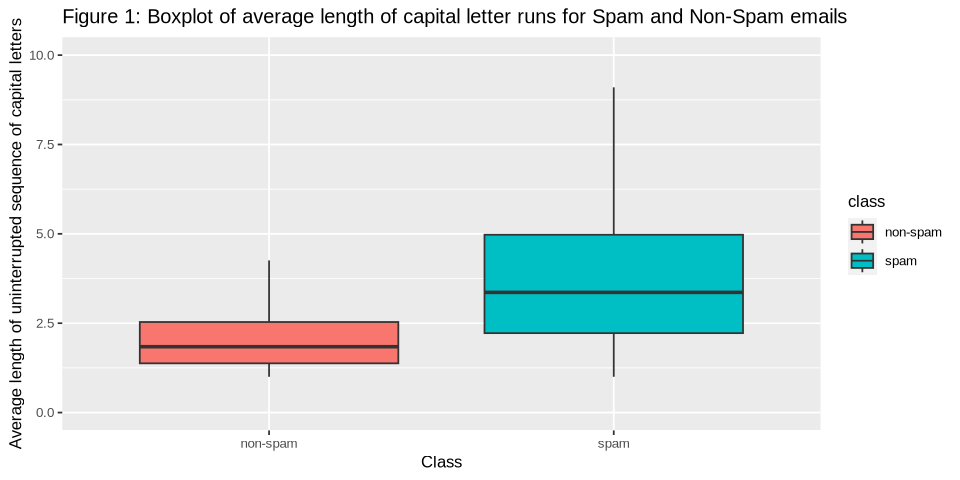

In [11]:
options(repr.plot.width = 8, repr.plot.height = 4)
spam_boxplot

Warning message:
“Removed 42 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


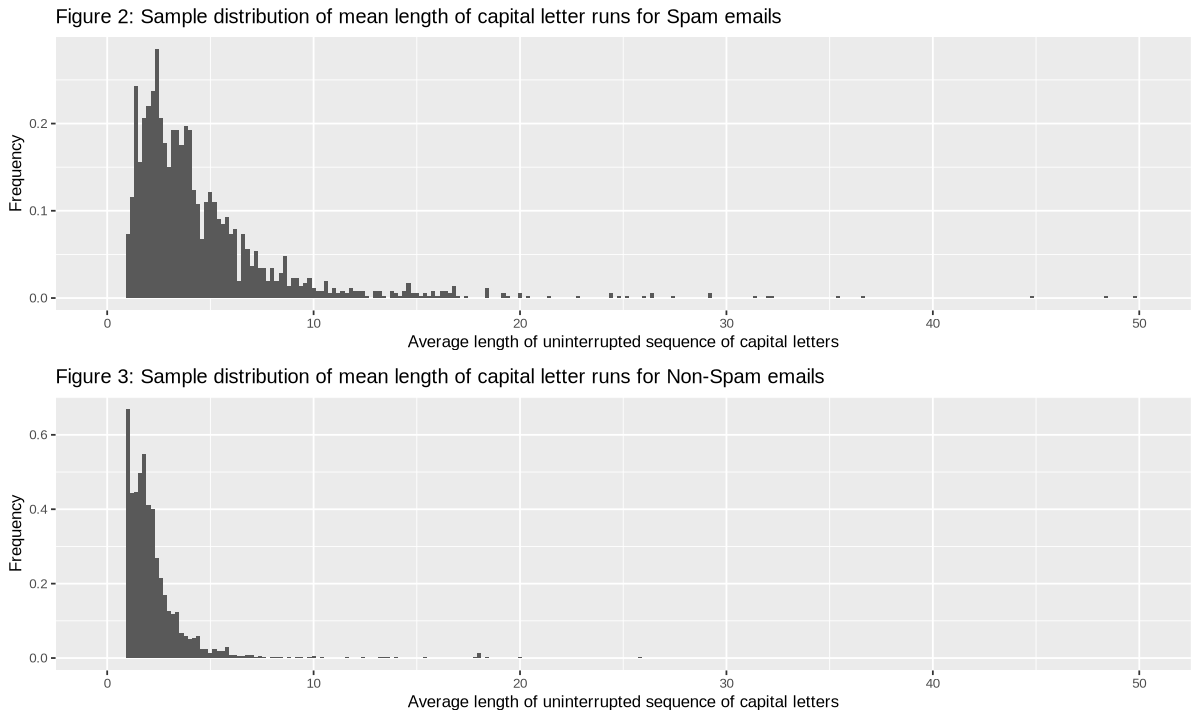

In [12]:
options(repr.plot.width = 10, repr.plot.height = 6)
plot_grid(spam_histogram, non_spam_histogram, ncol = 1)

*Note: some larger values/outliers are not pictured in order to fit the majority of values

Spam emails seem to typically have a greater average length with a wider spread.
The distributions for both are unimodal and strongly right-skewed.

Based on these results, we might believe spam has longer capital letter sequences. For instance, an email with unusually long sequences of capitals is suspect.

## Methods: Plan

Assuming `Spambase` is a representative sample, our estimates of the mean values for capital letter sequences of spam and non-spam emails are likely to be good approximations of the true values, especially given the samples' large size. However, our point estimates do not provide any measure of how close they are likely to be to the true values: we do not know their uncertainty. We cannot use these results without further work.

For our analysis, we build a confidence interval of the difference in means to obtain a range of values that we are confident contains the true difference. We also use both theory-based and bootstrapping-based approaches to conduct a hypothesis test.

We will perform a two-sample t-test, as well as a bootstraping-based hypothesis test, for the difference in means, using $H_0: \mu_1 = \mu_0$ vs $H_1: \mu_1\gt \mu_0$, where 1 and 0 represent spam and non-spam. If there is a difference, we would expect to gain evidence of it from these inferences. If our results are significant we will be able to safely reject the null hypothesis, and conclude that capital letter sequence length is a solid indicator of spam.

## Methods: Bootstrap Confidence Interval (Not a hypothesis test)
We begin by constructing a 95% confidence interval for the difference between the mean capital letter usage between spam and non-spam emails. While this cannot lead us to reject or fail to reject the null hypothesis by itself, it does give us an idea about how extreme the difference is between these two means.

In [13]:
set.seed(1048596)
spam_bootstrap_dist <- spambase_selected |> specify(formula=capital_run_length_average ~ class) |>
    generate(reps=1000, type="bootstrap") |>
    calculate(stat = "diff in means",order = c("spam","non-spam"))
    
spam_ci <- spam_bootstrap_dist |> get_confidence_interval(level=0.95,type="percentile")
spam_ci # here's a 95% confidence interval for the mean occurrences of spam in email.

lower_ci,upper_ci
<dbl>,<dbl>
5.059496,9.755062


We find that the difference between the means is highly significant: the lower bound for the *difference* is larger than the *actual mean* of non-spam emails.

This result means that if you were to take near a large number of samples from the population, we would expect 95% of these samples' point estimates for the differences between spam and non-spam capital letter usage to fall within this range.

## Methods: Bootstrap Hypothesis Testing

We consider a null hypothesis: that capital letter frequency is completely unrelated to classification as spam. We set alpha at 0.05, a common value used across many fields. The null hypothesis is what our data would look like if $H_0: \mu_1 = \mu_0$ were true, and there was no difference between the means of capital letter usage between the populations of spam and non-spam emails. By comparing our sample to this null model, we can determine how surprising it would be for our sample to have the results it does, if the null model were true.

Here, we create the null model for this null hypothesis.

We do a one-sided hypothesis test, because we do not expect that spam email will contain fewer capital letters on average than non-spam. We choose an alpha of 0.05, as this is a common choice for a significance cutoff across fields. We begin with bootstrapping, instead of a theory-based approach, as the theory-based approaches are but approximations for bootstrapping. However, we will do both over the course of this report, and this proves useful for reasons we shall soon cover.

In [14]:
set.seed(1337) # set the seed

obs_diff_in_means <- spambase_selected |> specify(formula = capital_run_length_average ~ class) |>
    calculate(stat="diff in means", order=c("spam","non-spam"))

null_diff_in_means <- spambase_selected |> specify(formula=capital_run_length_average ~ class) |>
    hypothesize(null="independence") |>
    generate(reps=1000, type="permute") |>
    calculate(stat = "diff in means",order = c("spam","non-spam"))
    
p_value <- null_diff_in_means |> get_p_value(obs_stat = obs_diff_in_means,direction="right")
print("Table X")
p_value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


[1] "Table X"


p_value
<dbl>
0


Attribution: The following code was adapted from tutorial \#6, and was further double-checked with a code generation model (no code written by the model was added to the report), since the authors of this report were incredulous at a p value of 0 (or, in reality, so close to 0 that R reported it as 0).

We visualize the results of our bootstrapping and demonstrate that yes, a p-value that is extremely close to 0 makes sense.

In [15]:
diff_in_means_plot <- # adapted from tutorial 6 solution
    visualize(null_diff_in_means, bins = 10) + 
    shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
    xlab("Figure 4: Difference in mean (red bar is the observed difference in means)") +
    theme(text = element_text(size = 20))

Warning message in min(diff(unique_loc)):
“no non-missing arguments to min; returning Inf”


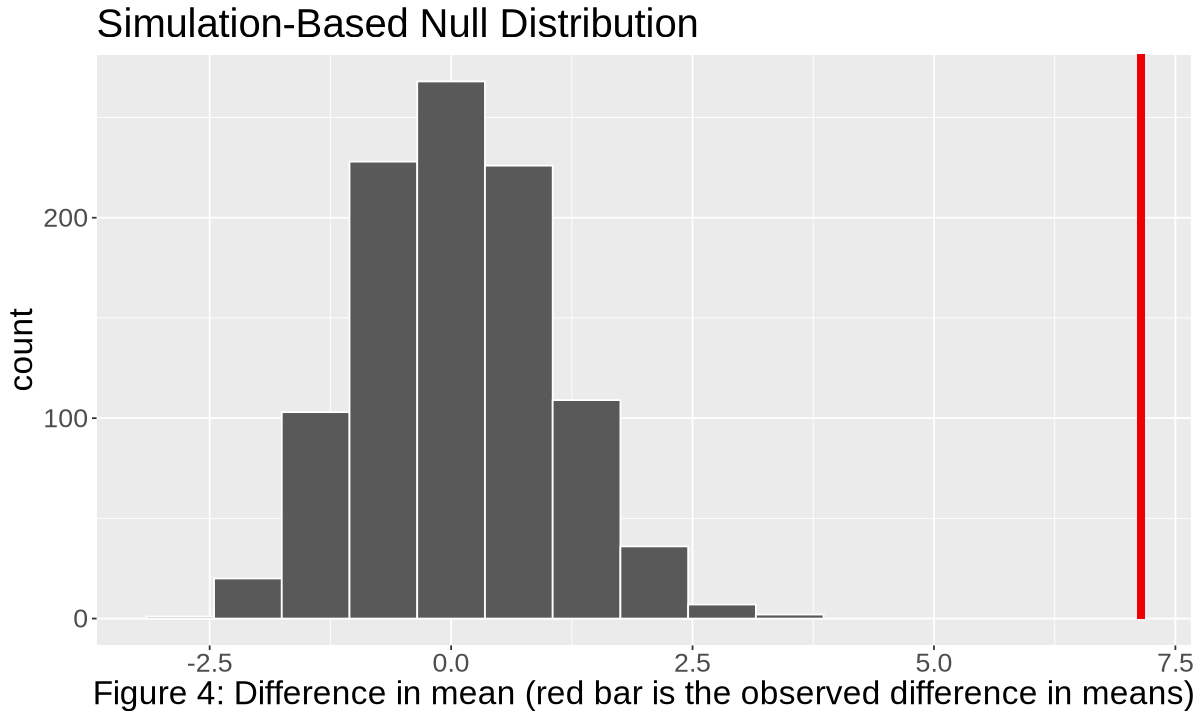

In [16]:
diff_in_means_plot

## Methods: Theory-based testing
Here we perform a t test to double-check the p value we acquired through bootstrapping. We confirm that the p value is infinitesimal. We note that though we originally favored the bootstrapping method of conducting a hypothesis test, our results were so significant that we could not actually attain a nonzero p value using that method and the computational resources at our disposal. Hence, the asymptotic approach has an advantage in that it lets us approximate just how small our small p value is.

Each method of approximation gave similar results, in that they were quite small, yet technically one is still infinitely larger than the other. However both are quite sufficient to reject the null hypothesis, so we deem neither particularly more trustworthy than the other: yes, a 0 p value is mathematically impossible, but it's unclear how far off the computed p value is from the real p value, at such a small size, so we do not necessarily trust the asymptotic value completely either.

In [18]:
set.seed(1048596)

# Two-sample T test.
print("Table 3: p Value Computed Using Asymptotics and a Two-Sample T-test.")
tidy(
    prop.test(
        x=c(nrow(filter(spambase_selected,class=="non-spam"))),
        n=c(nrow(spambase_selected)),
        p=0.5, # null hypothesis: there's no difference in the distribution
        alternative="greater",
        conf.level=0.95, # 0.05 conf interval TODO check
        correct=FALSE # don't use fancy statistical methods to fix stuff up
    )
)

[1] "Table 3: p Value Computed Using Asymptotics and a Two-Sample T-test."


estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>
0.606087,207.0817,2.975352e-47,1,0.594178,1,1-sample proportions test without continuity correction,greater


We have determined through multiple statistcal means that there does indeed exist a relationship between longer capital letter sequences, and an email's classification as spam. Our results acheive a p value of either 0, or $2.975^{-47}$, depending on the method; both of which are (quite) statistically significant against our alpha of 0.05. This leads us to reject the null hypothesis $H_0: \mu_1 = \mu_0$. This is the result we expected to find, given our preliminary analysis showed strong differences between the samples of spam and non-spam emails.

These results imply that the length of capital letter sequences is a fantastic indicator of whether or not an email is spam; we believe this can inform both individuals and AI model creators who are interested in keeping their inboxes relevant to them. We believe followup research could take advantage of results as strong as these to train a logistic regression model on capital letter sequence lengths alone, for extremely-computationally-lightweight spam detection capabilities. Future work could also progress towards identifying other categories in this dataset that are strongly correlated with an email being spam.